<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2023-2/notebooks/5b_agrupamento_espectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamiento espectral
En esta libreta veremos cómo descubrir comunidades en redes sociales usando agrupamiento espectral.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans, SpectralClustering

np.random.seed(2021)

## Grafo simple
Empezamos creando un grafo simple, del cual analizaremos el [espectro](https://en.wikipedia.org/wiki/Spectrum_of_a_matrix) de su matriz laplaciana.

In [2]:
G_simple = nx.Graph()
G_simple.add_nodes_from(range(10))
acom1 = [(i,j)for i in range(4) for j in range(4) if i != j]
acom2 = [(i,j)for i in range(4,8) for j in range(4,8) if i != j]
acom3 = [(i,j)for i in range(8,12) for j in range(8,12) if i != j]
G_simple.add_edges_from(acom1)
G_simple.add_edges_from(acom2)
G_simple.add_edges_from(acom3)
G_simple.add_edge(3,4)
G_simple.add_edge(2,5)
G_simple.add_edge(6,8)
G_simple.add_edge(7,9)
G_simple.add_edge(10,12)
G_simple.add_edge(11,12)
G_simple.add_edge(12,13)

Visualizamos el grafo creado.

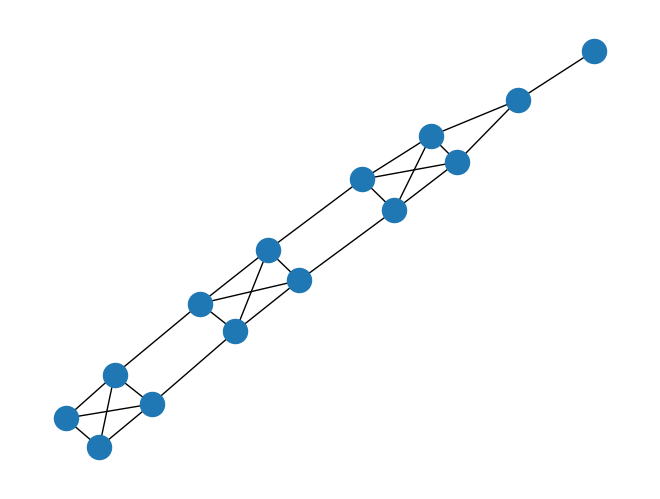

In [3]:
simple_pos = nx.spring_layout(G_simple)
nx.draw(G_simple, pos=simple_pos)

Obtenemos y desplegamos la matriz de adyacencia del grafo.

In [4]:
amat_simple = nx.linalg.adjacency_matrix(G_simple)
amat_simple = amat_simple.toarray()
print(amat_simple)

[[0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


Hacemos lo propio con la matriz de grado.

In [5]:
dmat_simple = np.diag(nx.linalg.laplacian_matrix(G_simple).diagonal())
print(dmat_simple)
print(dmat_simple.diagonal())

[[3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
[3 3 4 4 4 4 4 4 4 4 4 4 3 1]


Finalmente obtenemos y desplegamos la matriz laplaciana.

In [6]:
lmat_simple = nx.linalg.laplacian_matrix(G_simple)
lmat_simple = lmat_simple.toarray()
print(lmat_simple)

[[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  4 -1  0 -1  0  0  0  0  0  0  0  0]
 [-1 -1 -1  4 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  4 -1 -1 -1  0  0  0  0  0  0]
 [ 0  0 -1  0 -1  4 -1 -1  0  0  0  0  0  0]
 [ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
 [ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
 [ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
 [ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1  4 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  1]]


Calculamos los vectores y valores propios de la matriz laplaciana.

In [7]:
import scipy as sp
v0 = np.random.uniform(-1, 1, lmat_simple.shape[0])
eval_simple, evec_simple = sp.sparse.linalg.eigsh(lmat_simple.astype(np.float64), k=10, sigma=1.0, which='LM', tol=0.0, v0=v0)
#eval_simple, evec_simple = np.linalg.eigh(lmat_simple.astype(np.float64))

Verificamos que las restricciones se están cumpliendo.

In [8]:
print(np.sum(evec_simple**2, axis=0))
print(np.sum(evec_simple, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-3.74165739e+00  4.55191440e-15 -2.22044605e-16 -2.22044605e-16
 -5.55111512e-17  6.86950496e-16  2.34187669e-16  2.46330734e-16
 -4.71844785e-16  2.98372438e-16]


Ordenamos los valores propios de menor a mayor y mantenemos el mismo orden para los vectores propios correspondientes.

In [9]:
orden_idx = np.argsort(eval_simple)
eval_simple = eval_simple[orden_idx]
evec_simple = evec_simple[:, orden_idx]

Examinamos los valores propios ordenados.

In [10]:
print(eval_simple)

[-2.22044605e-16  2.50758251e-01  7.63932023e-01  1.37332602e+00
  3.24376387e+00  4.00000000e+00  4.00000000e+00  4.00000000e+00
  4.29185335e+00  5.00000000e+00]


Desplegamos el primer valor propio y su correspondiente vector propio. Nota que el valor propio más pequeño $\approx 0$ y que todos los elementos de su vector propio correspondiente son iguales.

In [11]:
print(eval_simple[0])
print(evec_simple[:, 0])

-2.220446049250313e-16
[-0.26726124 -0.26726124 -0.26726124 -0.26726124 -0.26726124 -0.26726124
 -0.26726124 -0.26726124 -0.26726124 -0.26726124 -0.26726124 -0.26726124
 -0.26726124 -0.26726124]


Visualizamos los elementos de los vectores propios con valor propio más pequeño.

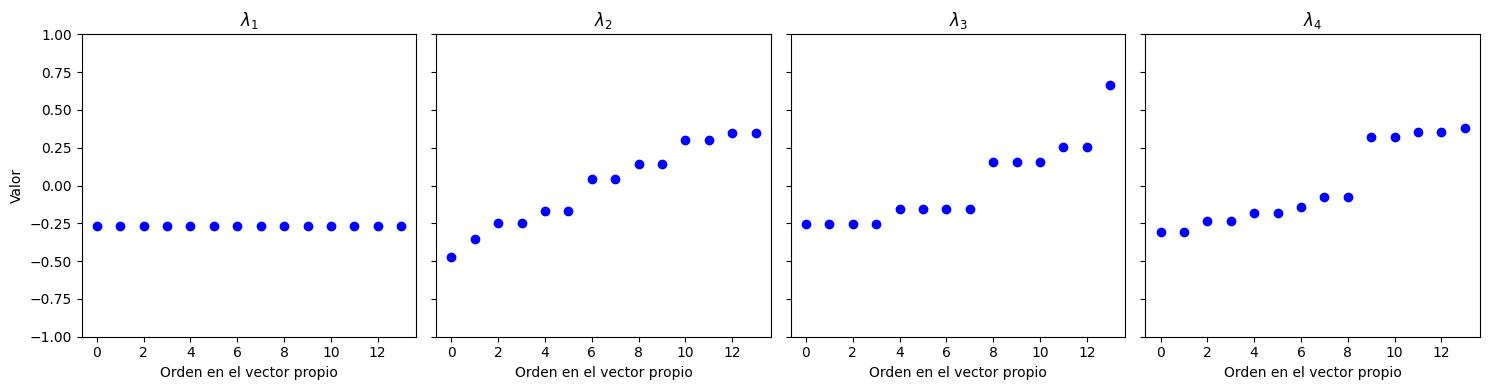

In [12]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

for i in range(4):
  axs[i].plot(np.sort(evec_simple[:, i]), 'bo')
  axs[i].set_ylim([-1,1])
  axs[i].set_xlabel('Orden en el vector propio')
  axs[i].set_title('$\\lambda_' + str(i + 1) + '$')

axs[0].set_ylabel('Valor')
fig.tight_layout()
plt.show()

Empleamos KMeans para agrupar los nodos usando los eigenvalores asociados.

In [13]:
km_simple = KMeans(n_clusters=3, n_init=100)
km_simple = km_simple.fit(evec_simple[:, [1]])
km_simple.labels_

array([1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

In [14]:
print(G_simple.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


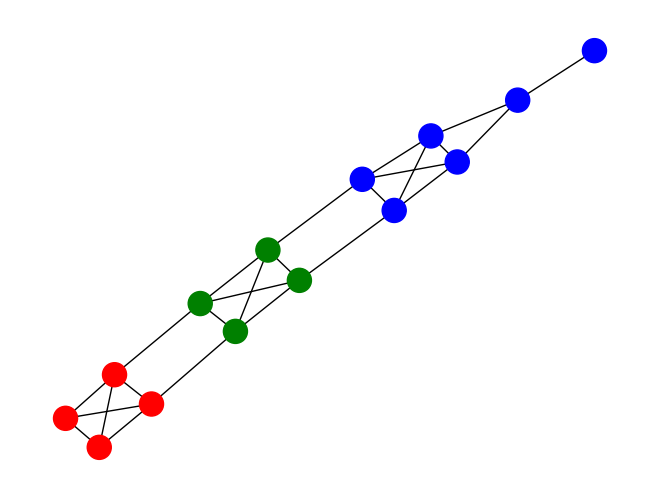

In [15]:
mapa_color = {0:'blue', 1:'red', 2:'green'}
color_vertices = [mapa_color[km_simple.labels_[n]] for n in G_simple]
nx.draw(G_simple, pos=simple_pos, node_color=color_vertices)

## Club de karate de Zachary
Hacemos el mismo análisis del grafo anterior usando el grafo del [Club de karate de Zachary](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), el cual está disponible en la biblioteca NetworkX. 

Primero, cargamos y visualizamos el grafo.


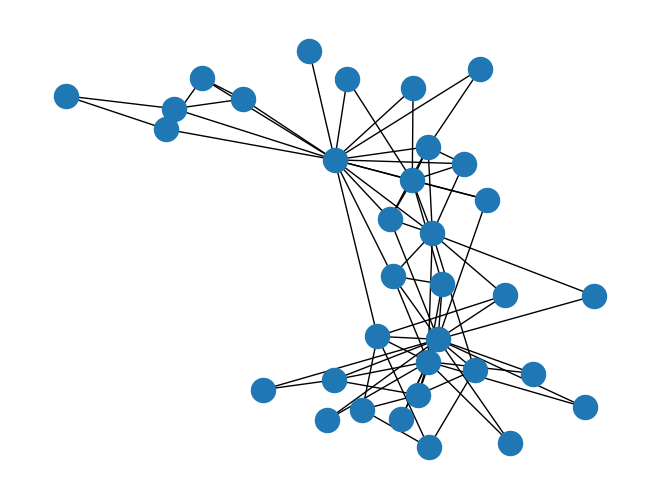

In [16]:
G_karate = nx.karate_club_graph()    
karate_pos = nx.spring_layout(G_karate)
nx.draw(G_karate)

Obtenemos su matriz de adyacencia y laplaciana.

In [17]:
lmat_karate = nx.linalg.laplacian_matrix(G_karate)
amat_karate = nx.linalg.adjacency_matrix(G_karate)
lmat_karate = lmat_karate.toarray()

Calculamos los vectores y valores propios de la matriz lapaciana.

In [18]:
eval_karate, evec_karate = np.linalg.eigh(lmat_karate.astype(np.float64))

Examinamos sus propiedades.

In [19]:
print(np.sum(evec_karate**2, axis=0))
print(np.sum(evec_karate, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-5.83095189e+00 -2.00117700e-14 -1.39124823e-15  2.62376926e-16
 -3.07913417e-16 -1.02088477e-15 -2.65586164e-15  1.14876641e-15
  3.88578059e-16  3.92047506e-16  3.88578059e-16  5.11743425e-16
  3.72965547e-16  1.30841518e-15  6.80011603e-16 -7.28583860e-16
 -3.62210262e-15  8.88178420e-16  4.30211422e-16  7.76288755e-16
 -3.81639165e-16 -1.42073853e-15  7.35522754e-16  1.76247905e-15
 -1.26981758e-15  2.24364798e-15  2.22738494e-15  2.22044605e-16
 -9.99200722e-16 -1.62370117e-15  2.24126273e-15  9.15933995e-16
 -5.03069808e-17  9.99200722e-16]


Ordenamos los vectores propios en orden ascendente al valor propio asociado.

In [20]:
orden_idx = np.argsort(eval_karate)
eval_karate = eval_karate[orden_idx]
evec_karate = evec_karate[:, orden_idx]

Desplegamos los valores propios ordenados.

In [21]:
print(eval_karate)

[-1.16292594e-14  1.18710730e+00  2.39431926e+00  2.93182048e+00
  2.96830180e+00  3.06104079e+00  3.12126310e+00  3.70606484e+00
  3.80094429e+00  4.16160574e+00  4.54469763e+00  4.69727550e+00
  4.97817925e+00  5.16855490e+00  5.59481244e+00  6.44605541e+00
  6.97788032e+00  9.18096651e+00  1.00106981e+01  1.02218147e+01
  1.18744202e+01  1.20754027e+01  1.43813508e+01  1.48885752e+01
  1.70337951e+01  1.93238240e+01  2.13586504e+01  2.27849630e+01
  2.55555039e+01  2.96883840e+01  3.79927558e+01  4.18328632e+01
  4.59907681e+01  5.20653410e+01]


Examinamos el vector propio asociado al valor propio más pequeño.

In [22]:
print(eval_karate[0])
print(evec_karate[:, 0])

-1.1629259439989111e-14
[-0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859
 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859
 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859
 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859
 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859 -0.17149859
 -0.17149859 -0.17149859 -0.17149859 -0.17149859]


Graficamos los elementos de los vectores propios asociados a los cuatro valores propios más pequeños.

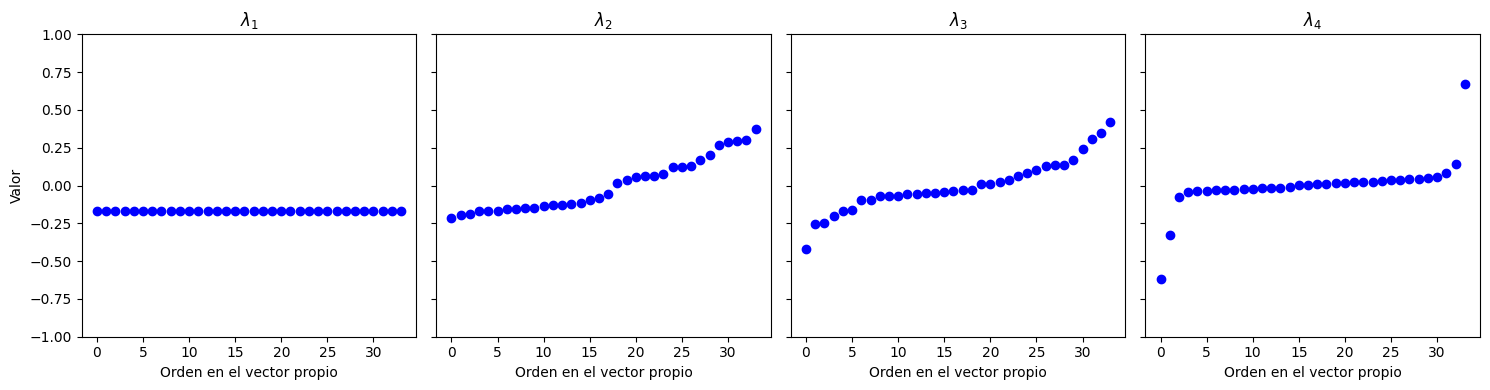

In [23]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

for i in range(4):
  axs[i].plot(np.sort(evec_karate[:, i]), 'bo')
  axs[i].set_ylim([-1,1])
  axs[i].set_xlabel('Orden en el vector propio')
  axs[i].set_title('$\\lambda_' + str(i + 1) + '$')

axs[0].set_ylabel('Valor')
fig.tight_layout()
plt.show()

Agrupamos los elementos del vector propio con valor propio más pequeño.

In [24]:
km_karate = KMeans(n_clusters=3, n_init=100)
km_karate = km_karate.fit(evec_karate[:, [1]])
km_karate.labels_

array([2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Visualizamos el agrupamiento de los vértices.

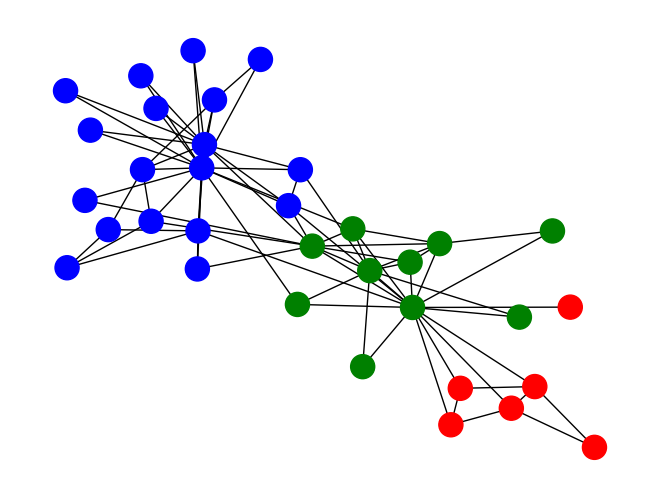

In [25]:
color_vertices = [mapa_color[km_karate.labels_[n]] for n in G_karate]
nx.draw(G_karate, pos=karate_pos, node_color=color_vertices)

## Detección de comunidades en _Facebook's Social circles_
Aplicamos agrupamiento espectral a los [círculos sociales de Facebook de SNAP](https://snap.stanford.edu/data/ego-Facebook.html).

Primero descargamos y desempaquetamos los datos.

In [26]:
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip facebook_combined.txt.gz

--2023-04-25 19:02:23--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   370KB/s    in 0.6s    

2023-04-25 19:02:24 (370 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]



Cargamos el grafo y lo visualizamos.

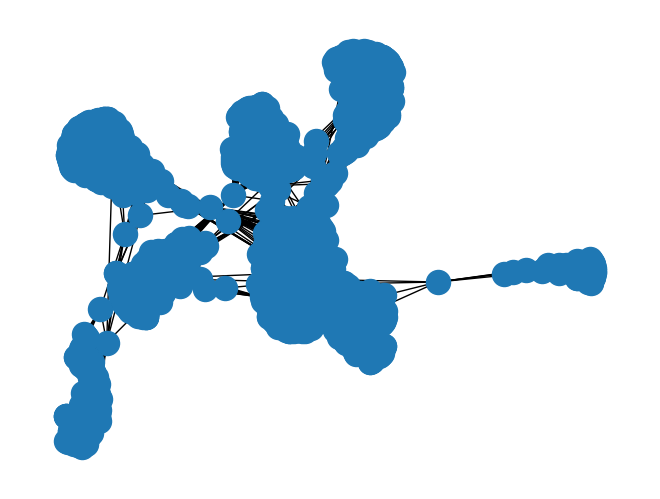

In [27]:
G_large = nx.read_edgelist('facebook_combined.txt')
large_pos = nx.spring_layout(G_large)
nx.draw(G_large, pos=large_pos)

Obtenemos su matriz laplaciana y le aplicamos agrupamiento espectral para obtener 10 comunidades

In [31]:
amat_large = nx.linalg.adjacency_matrix(G_large)
sc_large = SpectralClustering(n_clusters=10, 
                              affinity='precomputed', 
                              n_init=100)
sc_large = sc_large.fit(amat_large.toarray())

Visualizamos las comunidades

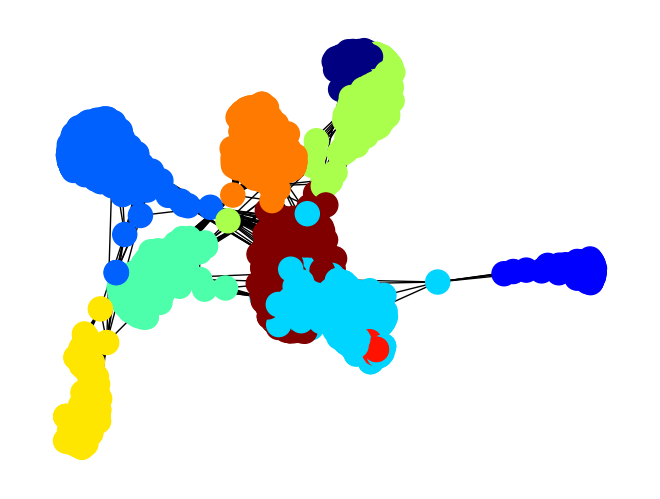

In [32]:
nx.draw(G_large, pos=large_pos, node_color=sc_large.labels_, cmap=plt.cm.jet)